In [ ]:
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")
base_path = './drive/MyDrive/Colab Notebooks/Data/ML/HW2/'

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from graphviz import Digraph
from math import log,sqrt
import pdb

In [ ]:
# data = pd.read_csv(base_path + 'D2.txt', sep = " ", header = None)
# data = pd.read_csv(base_path + 'D1.txt', sep = " ", header = None)
# data = pd.read_csv(base_path + 'Dbig.txt', sep = " ", header = None)
data = pd.read_csv(base_path + 'D3leaves.txt', sep = " ", header = None)
# data = pd.read_csv(base_path + 'Druns.txt', sep = " ", header = None)
# print(data)
data.rename(columns={0: "x1", 1: "x2", 2: "y"}, inplace=True)
data

tree = Digraph()
node_count = 0
lev = 1
decisionthresholds = []

In [ ]:
class Node():
  def __init__(self, data: pd.DataFrame):
    global node_count
    self.best_feature = None
    self.best_value = None
    self.predicted_value = None
    self.data = data
    self.left_node = None
    self.right_node = None
    node_count += 1
    self.counts = Counter(data['y']) 
    counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))
    self.yhat = None
    if len(counts_sorted) > 0:
      self.yhat = counts_sorted[-1][0]

  def entropy(self,*probs):
    total = sum(probs)
    return sum([-p / total * log(p / total, 2) if p != 0 else 0 for p in probs])


  def candidatesplits(self,data):
    candsplit = {}
    for column in data.columns[:-1]:
      data = data.sort_values(column)
      c = []
      S = set(data[column].values.flatten())
      S = sorted(list(S))
      # print(len(S)-1)
      for i in range(len(S)-1):
        df1 = data[data[column] == S[i]]
        df2 = data[data[column] == S[i+1]]
        # print(df2)
        for index1, row1 in df1.iterrows() :
          for index2, row2 in df2.iterrows():
            # print(row1.iloc[2],row2.iloc[2])
            if row1.iloc[-1] != row2.iloc[-1]:
              c.append(row2.loc[column])
      if c: #there will be no candsplit if all y labels are same
        candsplit[column] = list(set(c))

    # print(c)
    return candsplit

  def calculateInfoGain(self, data, label, threshold = None):
    classes, class_counts = np.unique(data['y'], return_counts=True)
    dy_entropy =  self.entropy(class_counts[0], class_counts[1])

    left_counts = Counter(data[data[label]<threshold]['y'])
    right_counts = Counter(data[data[label]>=threshold]['y'])
    # print(left_counts, right_counts)
    # Getting the Y distribution from the dicts
    y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)
    # print(y0_left, y1_left, y0_right, y1_right)
    entropy_left = self.entropy(y0_left, y1_left)
    entropy_right = self.entropy(y0_right, y1_right)

    n_left = y0_left + y1_left
    n_right = y0_right + y1_right

    w_left = n_left / (n_left + n_right)
    w_right = n_right / (n_left + n_right)

    info_gain = dy_entropy - (w_left * entropy_left + w_right * entropy_right)

    candidate_feature_entropy = self.entropy(y0_left+y1_left, y0_right + y1_right)
    return info_gain/candidate_feature_entropy #Info gain ratio

  def getbestSplit(self, data, candsplit):
    max_info = 0
    best_feature = None
    best_value = None
    for feature in candsplit:
      for threshold in candsplit[feature]:
        info_gain = self.calculateInfoGain(data, feature, threshold=threshold)
        # print(feature + "-  " + str(threshold) + " " + str(info_gain))
        if info_gain > max_info:
          max_info = info_gain
          best_feature = feature
          best_value = threshold
    return best_feature, best_value
      

  def buildtree(self, level):
      global lev, tree, decisionthresholds
      #root
      # pdb.set_trace()
      # print(self.data)
      
      if(self.data.empty or len(self.data)==1):
        return None,None
      y_counters = Counter(self.data['y'])
      candsplit = self.candidatesplits(data= self.data)
      # print(candsplit)
      if(not candsplit):
        return None,None
      best_feature, best_value = self.getbestSplit(self.data, candsplit=candsplit)
      # print(best_feature, best_value)
      
      threshold_row = self.data[data[best_feature] == best_value]
      decisionthresholds.append([threshold_row['x1'].values[0], threshold_row['x2'].values[0]])

      #Save best split for current node
      self.best_feature = best_feature
      self.best_value = best_value
      lev = level
      left_data = self.data[self.data[best_feature] < best_value]
      right_data = self.data[self.data[best_feature] >= best_value]

      #Create left node
      left_node = Node(left_data)
      self.left_node = left_node
      self.left_node.best_feature,self.left_node.best_value =  self.left_node.buildtree(level+1)
      if self.left_node.best_feature:
        tree.edge(self.best_feature + '\n' + str(self.best_value),
                  self.left_node.best_feature + '\n' + str(self.left_node.best_value),
                  "<" + str(self.best_value))
      else:
        tree.edge(self.best_feature+ '\n' + str(self.best_value), 
                  "L Leaf" + str(self.best_value) + '\n Y = ' + str(self.left_node.yhat),
                  "<" + str(best_value))
      

      #Create Right Node
      right_node = Node(right_data)
      self.right_node = right_node
      self.right_node.best_feature, self.right_node.best_value = self.right_node.buildtree(level + 1)
      if self.right_node.best_feature:
        # print("tree heyeyyeyyyy")
        tree.edge(self.best_feature+ '\n' + str(self.best_value),
                  self.right_node.best_feature + '\n' + str(self.right_node.best_value),
                  ">=" + str(self.best_value))
      else:
        # print("tree heyeyyeyyyy leaffff")
        tree.edge(self.best_feature+ '\n' + str(self.best_value),
                  "R Leaf" + str(self.best_value) + '\n Y = ' + str(self.right_node.yhat),
                  ">=" + str(self.best_value)) 

      
      return self.best_feature,self.best_value

  def predict(self, test_features):
    """
    Method to predict new values
    """
    
    predictions = []
    for index, row in test_features.iterrows():
      predictions.append(self.traverse_tree(row))

    return predictions

  def traverse_tree(self, row):

    curr_node = self
    # pdb.set_tr ace()
    while(curr_node.left_node and curr_node.right_node):

      if row[curr_node.best_feature] < curr_node.best_value :
        curr_node = curr_node.left_node
      else:
        curr_node = curr_node.right_node


    return curr_node.yhat

In [ ]:
# tree = Digraph()
# node_count = 0
# lev = 1
# decisionthresholds = []

# root = Node(data)
# root.buildtree(lev)
# tree

# t_row = data[data['x2'] == 0.564388]
# t_row['x1'].values[0]
# data.head()

root.entropy(3,1)


0.8112781244591328

In [ ]:
# data = data[1:]
# data.at[3,'y'] = 0
# data.at[3,'y'] = 0
# data.loc[4].y = 0
# data
data_sets = []
data_sets.append(data)


In [ ]:
treelist = []
nodes_list = []
data_sets = []
def genTrees(data):
  global node_count, lev
  for i in range(5,14,2):
    tree = Digraph()
    node_count = 0
    lev = 1
    temp_data = data[:2**i]
    temp_root = Node(temp_data)
    temp_root.buildtree(lev)
    print("Total Nodes = " + str(node_count) + " Levels = " + str(lev+1))
    treelist.append(temp_root)
    nodes_list.append(node_count)
    data_sets.append(temp_data)

  

data = data.sample(frac=1).reset_index(drop=True)
# genTrees(data[:8192])
data_test = data[8192:]

genTrees(data)

Root Mean Square Error: 0.31022401269582167
Root Mean Square Error: 0.25869823880548926
Root Mean Square Error: 0.20903274926548404
Root Mean Square Error: 0.17121378242429958
Root Mean Square Error: 0.12444567354358614


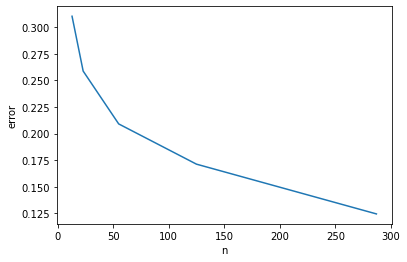

In [ ]:
def calculateError(treelist, test):
  error_list = []
  for root in treelist:
    y_predicted = root.predict(test_features=test)
    y_actual = test['y'].values.tolist()
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
 
    RMSE = sqrt(MSE)
    print("Root Mean Square Error: " + str(RMSE))
    # print(RMSE)
    error_list.append(RMSE)
  return error_list

test = data_test
errorlist = calculateError(treelist, test)

plt.xlabel('n')
plt.ylabel('error')
plt.plot(nodes_list, errorlist)
# errorlist

Root Mean Square Error: 0.3956343623506007
Root Mean Square Error: 0.2629394761947945
Root Mean Square Error: 0.21936150306411714
Root Mean Square Error: 0.1595069837847428
Root Mean Square Error: 0.11759010854794967


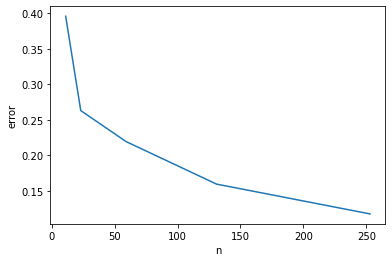

In [ ]:
from sklearn.tree import DecisionTreeClassifier

error_list_sklearn = []
nodes_list_sklearn = []
for data in data_sets:
  X_train = np.array(data.drop('y', axis=1, inplace=False))
  y_train = np.array(data['y'])
  clf = DecisionTreeClassifier()
  # Train Decision Tree Classifer
  clf = clf.fit(X_train,y_train)
  X_test = np.array(data_test.drop('y', axis=1, inplace=False))
  y_actual = np.array(data_test['y'])
  #Predict the response for test dataset
  y_pred = clf.predict(X_test)
  MSE = np.square(np.subtract(y_actual,y_pred)).mean() 
  
  RMSE = sqrt(MSE)
  print("Root Mean Square Error: " + str(RMSE))
  # print(RMSE)
  error_list_sklearn.append(RMSE)
  nodes_list_sklearn.append(clf.tree_.node_count)


plt.xlabel('n')
plt.ylabel('error')
plt.plot(nodes_list_sklearn, error_list_sklearn)

In [ ]:
nodes_list_sklearn

[11, 23, 59, 131, 253]

In [ ]:
root = Node(data)
root.buildtree(lev)
print("Total Nodes = " + str(node_count) + " Levels = " + str(lev+1))
tree

In [ ]:
# test = pd.DataFrame({'x1' : 50, 'x2':7, 'y' : 1 }, index = [0])
test = data
# print(test)
# %pdb off
y_predicted = root.predict(test_features=test)
print(y_predicted)
y_actual = data['y'].values.tolist()
print(y_actual)
MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
 
RMSE = sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 

In [ ]:
from statistics import mean
xs = np.array([x[0] for x in decisionthresholds])
ys = np.array([x[1] for x in decisionthresholds])
def best_fit_slope_and_intercept(xs,ys):
    
    m = ( (mean(xs) * mean(ys)) - mean(xs * ys) ) / ( (mean(xs))**2 - mean(xs ** 2) )
    b = mean(ys) - m * mean(xs)
    return m,b

m,b = best_fit_slope_and_intercept(xs,ys)

regression_line = [(m*x + b) for x in xs]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


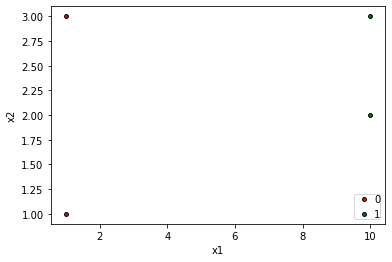

In [ ]:
for data in data_sets: 
  x1 = np.array(data['x1'].values).flatten()
  x2 = np.array(data['x2'].values).flatten()
  y = np.array(data['y'].values).flatten()
  # print(len(set(x1)), len(set(x2)))
  # n_classes = list(set(y))
  plot_colors = 'rb'
  # Plot the training points
  plt.xlabel('x1')
  plt.ylabel('x2')
  plots = [] 
  for i, color in zip(range(2), 'rg'):
    idx = np.where(y == i)
    plt.scatter(x1[idx], x2[idx], c=color, label=i,
                cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
  # plt.plot([x[0] for x in decisionthresholds], [x[1] for x in decisionthresholds])
  # plt.plot(xs,regression_line)
    plt.legend(loc='lower right', borderpad=0, handletextpad=0)
  plt.show()


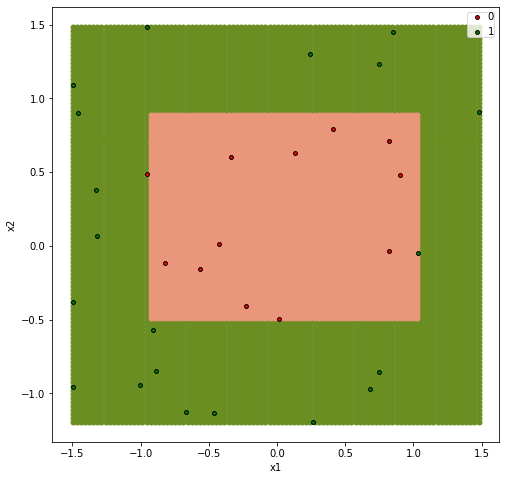

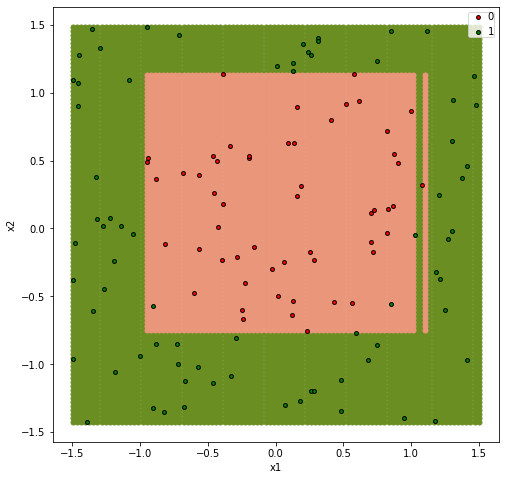

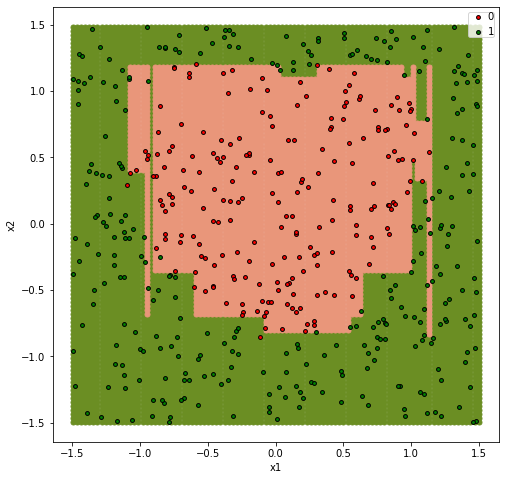

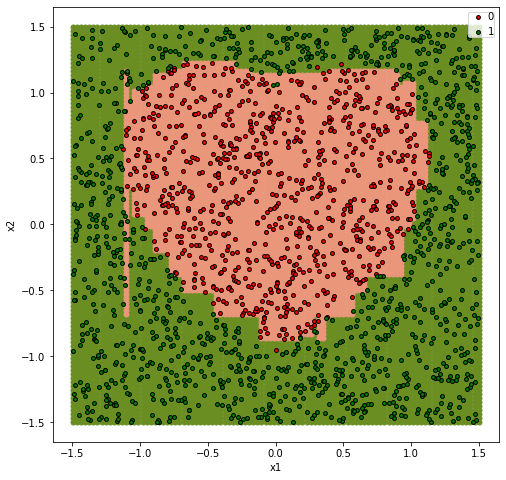

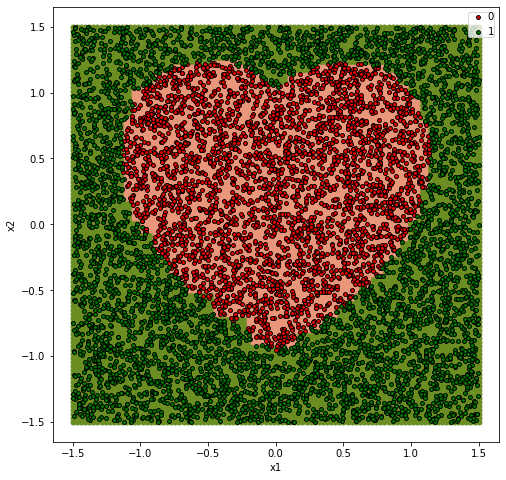

In [ ]:
for data, model in zip(data_sets, treelist): 
  traindata = np.array(data[['x1','x2']])
  numgridpoints = 100
  X,Y = np.meshgrid(np.linspace(min(traindata[:,0]),max(traindata[:,0]),numgridpoints), np.linspace(min(traindata[:,1]),max(traindata[:,1]),numgridpoints))
  X_1=X.flatten()
  Y_1 = Y.flatten()
  X_test_plot = np.stack((X_1,Y_1)).T
  testdataplot = X_test_plot.tolist()

  testdataplot
  testdf = pd.DataFrame(testdataplot, columns=['x1','x2'])
  testdf['y'] = 0
  testdf.head()

  plotpred = np.array(model.predict(testdf))

  plt.figure(figsize=(8,8))
  plt.scatter(X_test_plot[plotpred>0,0],X_test_plot[plotpred>0,1], s=25, color='olivedrab', marker="o")
  plt.scatter(X_test_plot[plotpred<=0,0],X_test_plot[plotpred<=0,1], s=25, color='darksalmon', marker="o")

  x1 = np.array(data['x1'].values).flatten()
  x2 = np.array(data['x2'].values).flatten()
  y = np.array(data['y'].values).flatten()
  # print(len(set(x1)), len(set(x2)))
  # n_classes = list(set(y))
  plot_colors = 'rb'
  # Plot the training points
  plt.xlabel('x1')
  plt.ylabel('x2')
  plots = [] 
  for i, color in zip(range(2), 'rg'):
    idx = np.where(y == i)
    plt.scatter(x1[idx], x2[idx], c=color, label=i,
                  cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
  # plt.plot([x[0] for x in decisionthresholds], [x[1] for x in decisionthresholds])
  # plt.plot(xs,regression_line)
  plt.legend(loc='upper right', borderpad=0, handletextpad=0)
  # plt.xlim([-0.2, 0.3])
  plt.show()